# Full data preprocessing for C-GAN

In [17]:
# Traditional imports
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Music and image imports
from imageio import imwrite
from music21 import converter, instrument, note, chord, converter
from PIL import Image, ImageOps
import mido

## Converting midi file to images and vice versa

### From midi file to image

In [9]:
# Intermediary function
def extractNote(element):
    return int(element.pitch.ps)

In [10]:
# Intermediary function
def extractDuration(element):
    return element.duration.quarterLength

In [11]:
# Intermediary function
def get_notes(notes_to_parse):

    """
    Get all the notes and chords from the midi files into a dictionary containing:
        - Start: unit time at which the note starts playing
        - Pitch: pitch of the note
        - Duration: number of time units the note is played for
    """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))

        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start":start, "pitch":notes, "dur":durations}

In [21]:
def midi2image(midi_path, output_folder_path, max_repetitions = float("inf"), resolution = 0.25, lowerBoundNote = 21, upperBoundNote = 127, maxSongLength = 100):

    """
    1) Transform a midi file into a set of images:
        - Each image has a size of 106 (all notes between lowerBound and upperBound) x 106 time units (maxSongLength)
        - One time unit corresponds to 0.25 (resolution) beat from the original music
    2) Store images into the corresponding sub-folder (identified by music piece name) of the 'output_folder_path' folder
    """

    output_folder = f"{output_folder_path}{midi_path.split('/')[-1].replace('.mid', '')}"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    mid = converter.parse(midi_path)

    instruments = instrument.partitionByInstrument(mid)

    data = {}

    try:
        i=0
        for instrument_i in instruments.parts:
            notes_to_parse = instrument_i.recurse()

            notes_data = get_notes(notes_to_parse)
            if len(notes_data["start"]) == 0:
                continue

            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = notes_data
                i+=1
            else:
                data[instrument_i.partName] = notes_data

    except:
        notes_to_parse = mid.flat.notes
        data["instrument_0"] = get_notes(notes_to_parse)

    for instrument_name, values in data.items():

        pitches = values["pitch"]
        durs = values["dur"]
        starts = values["start"]

        index = 0
        while index < max_repetitions:
            matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))


            for dur, start, pitch in zip(durs, starts, pitches):
                dur = int(dur/resolution)
                start = int(start/resolution)

                if not start > index*(maxSongLength+1) or not dur+start < index*maxSongLength:
                    for j in range(start,start+dur):
                        if j - index*maxSongLength >= 0 and j - index*maxSongLength < maxSongLength:
                            matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255

            if matrix.any(): # If matrix contains no notes (only zeros) don't save it
                output_filename = os.path.join(output_folder, midi_path.split('/')[-1].replace(".mid",f"_{instrument_name}_{index}.png"))
                imwrite(output_filename,matrix.astype(np.uint8))
                index += 1
            else:
                break

In [22]:
# Testing the function
midi2image('../../data_test/Input_midi/ballade2.mid', '../../data_test/Input_image/')

### From image to midi file

In [13]:
# Intermediary function
def column2notes(column, lowerBoundNote = 21):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

In [14]:
# Intermediary function
def updateNotes(newNotes, prevNotes, resolution = 0.25): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

In [15]:
def image2midi(image_path, lowerBoundNote = 21, resolution = 0.25):
    """
    From an existing image:
        - Convert to notes
        - Save result as a midi file in the subfolder 'music_piece_name' of the 'data_output_sound' folder 
    """
    
    output_folder = f"../../data_output_midi/{image_path.split('/')[-2]}"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    output_filename = os.path.join(output_folder, image_path.split("/")[-1].replace(".png",".mid"))
    print(output_filename)
    
    with ImageOps.grayscale(Image.open(image_path)) as image:
        im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
        print(im_arr.shape)
        try:
            im_arr = im_arr.reshape((image.size[1], image.size[0]))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])
    
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{}, resolution = resolution)
    for column in im_arr.T[1:,:]:
        notes = column2notes(column, lowerBoundNote=lowerBoundNote)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)
    
    midi_stream.write('midi', fp=output_filename)

In [16]:
# Testing the function
image_path = "../../ChopAI/data_raw/"
image2midi(image_path)

../../data_output_midi/data_raw/


NameError: name 'ImageOps' is not defined

## From midi files, create a clean image dataset

In [25]:
def get_clean_midi_data_as_images(midi_path, output_folder_path, image_height = 106, image_length = 106):

    """
    Iterate on all midi files from the 'midi_path' folder to:
        - Keep music pieces with one piano only
        - Transform the midi file into images
        - Store all corresponding images into a 'music_piece' subfolder of the 'output_folder_path'
    """
    # Storing all midi files into a 'files_raw' list
    files_raw = [file for file in os.listdir(midi_path)]

    # Storing all midi files with only one piano in a 'files' list
    files = []
    for file in files_raw:
        try:
            mid = converter.parse(f'{midi_path}/{file}')
            file_instruments = instrument.partitionByInstrument(mid)
            if len(file_instruments)==1:
                files.append(file)
        except:
            pass

    # Iterating on all files from 'files' list to create images
    for file in files:
        file_path = f"{midi_path}/{file}"
        midi2image(file_path, output_folder_path)

In [26]:
# Testing the function
midi_path ='../../data_test/Input_midi/'
output_folder_path = '../../data_test/Input_image/'
get_clean_midi_data_as_images(midi_path, output_folder_path)

In [48]:
def clean_images(input_path, output_path, height_image = 106, length_image = 106):
    """
    Iterate on all images created in the 'input_path' folder:
        - Resize images to height_image x length_image
        - Transform them into pure black and white images
        - Save them in a 'music piece' subfolder of the 'output_path' folder
       
    --> Input path: path to folder with input images (e.g., '../../data_test/Input_image')
    --> Output path: path to folder where we wish to save output reshaped images (e.g., '../../data_test/Input_image_cleaned')
    """
    
    for music in os.listdir(input_path):
        
        output_folder = f'{output_path}/{music}' # Creating one sub_folder for each music piece in the 'output_path' folder
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        for image in os.listdir(f"{input_path}/{music}"):
            image_path = f'{input_path}/{music}/{image}'
            image_read = Image.open(image_path) # Reading each image
            new_image = image_read.resize((106,106)) # Resizing each image
            new_image = new_image.convert("1") # Convert each image to pure black and white
            new_image.save(f'{output_folder}/{image}') # Saving each image

In [65]:
# Testing the function
clean_images('../../data_test/Input_image', '../../data_test/Input_image_cleaned')

## Get clean array dataset from clean image dataset

In [62]:
pixels = []
images = []

input_path = '../../data_test/Input_image_cleaned'
for music in os.listdir(input_path):
    for image in os.listdir(f"{input_path}/{music}"):
        image_path = f'{input_path}/{music}/{image}'
        image_read = Image.open(image_path) # Reading each image
        pixels_image = np.array(image_read.getdata()).astype('float32') # Store all pixel values in an array, each i_th-sequence contains the values of pixels in a i_th-row
        pixels_image = pixels_image / 255.0 # All the values are 0 (black) and white (255). Normalize pixel values to be between 0 and 1
        pixels.append(pixels_image.reshape(106, 106,1)) # Reshape pixels to be a matrix
        images.append(image_read)

pixels = np.array(pixels)
np.unique(pixels)

array([0., 1.], dtype=float32)

In [63]:
pixels.shape

(43, 106, 106, 1)

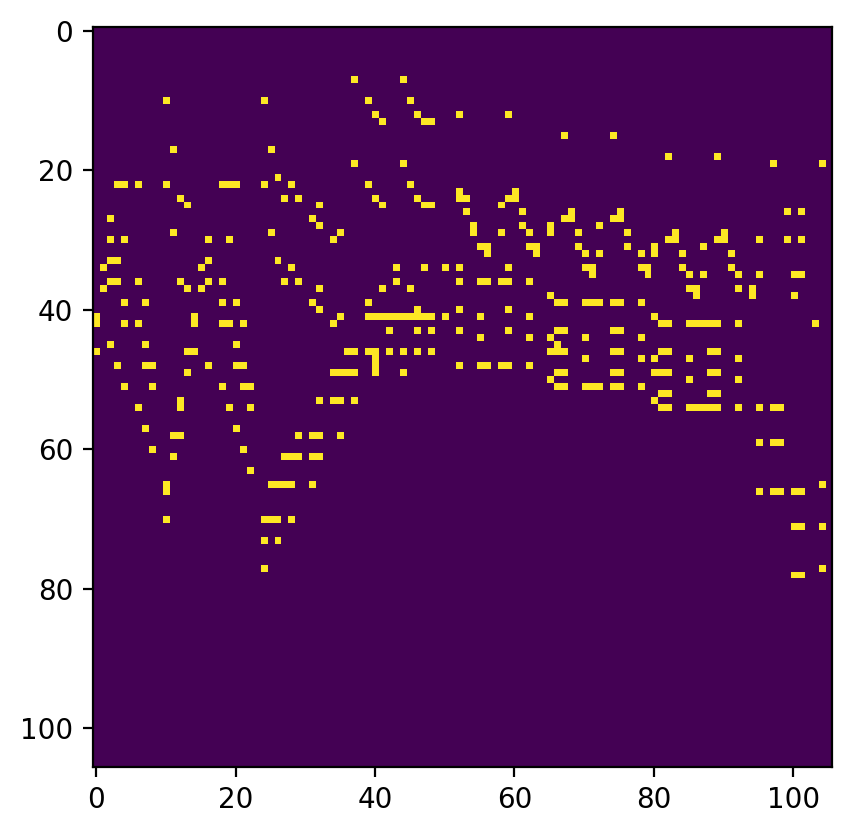

In [67]:
def show_image_from_pixels(matrix_of_pixels):
  plt.imshow(np.squeeze(matrix_of_pixels))
  plt.show()

show_image_from_pixels(pixels[12, :, :, :])